In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import alphalens
import seaborn as sns 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
basic1=pd.read_csv('所有基本信息.csv')
basic=basic1.drop('Unnamed: 0',axis=1)
basic=basic.rename(columns={'sid':'fund_code'})
position1=pd.read_csv('所有持仓.csv')
position=position1.drop('Unnamed: 0',axis=1)
industry1=pd.read_csv('所有行业映射.csv')
industry=industry1.drop('Unnamed: 0',axis=1)
nav1=pd.read_csv('净值all.csv')
nav=nav1.drop('Unnamed: 0',axis=1)
top10=pd.read_csv('重仓.csv')

In [3]:
#补充持仓
position1=position[position['date']==position['date'].tolist()[-1]]
position1['date']=nav['date'].tolist()[-1]  #把持仓拉满到2023-03-23
position_all=pd.concat([position,position1])
position_all['date']=pd.to_datetime(position_all['date']).astype('datetime64[ns]')

#辅助生成交易日序列
businessday=pd.read_csv('偏股混合型基金指数.csv')
businessday['date']=businessday['date'].astype('datetime64[ns]')  
businessday_1=businessday[['date']]
businessday_1.drop([len(businessday_1)-1],inplace=True)
businessday_1['date']=businessday_1['date'].astype('datetime64[ns]')  

In [4]:
########################################################################################生成最新四期股票仓位大于0.6的基金池
basic1=basic[(basic['isinitial']==1)&(basic['status_o']==101001000)&(basic['grading_flg']=='非分级基金')] 
basic2=basic1[basic1['investtype2'].isin(['普通股票型基金','偏股混合型基金','平衡混合型基金','灵活配置型基金'])]#筛选出主动偏股型公募基金
basic_fund=pd.DataFrame(basic2['fund_code'])
basic_fund['basic']=1
position_1=position_all.merge(basic_fund,how='left',on='fund_code')
position_1=position_1.dropna(how='any') #只保存上述筛选条件下的基金
position_stock=pd.DataFrame(position_1.groupby(['date','fund_code']).sum()['stock_ratio']).reset_index()  #不同时间不同基金的股票仓位

df_frame=position_stock.set_index(['date','fund_code']).unstack()['stock_ratio']
df_frame_1=df_frame.rolling(4).mean()>=0.6  #若最近4期平均股票持仓>=0.6则为true
df_frame_2=df_frame_1.resample('D').ffill() #形成每天的框架
df_frame_3=pd.DataFrame(df_frame_2.stack()).rename(columns={0:'yes'}).reset_index() 

In [5]:
#生成基金池净值
nav['date']=nav['date'].astype('datetime64[ns]')
nav_all=pd.merge(nav.drop_duplicates(['date','fund_code']),df_frame_3,how='inner',on=['date','fund_code'])   #选定基金池净值
nav_all_1=nav_all.set_index(['date','fund_code']).unstack()['adjnav']
nav_all_2=pd.merge(nav_all_1,businessday_1,how='inner',on='date').set_index('date') #只剩下交易日的净值
fund_nav_final=nav_all_2[df_frame_2] 

#生成基金池持仓
position_fund=position_all.merge(df_frame_3,how='left',on=['date','fund_code']).dropna(how='any')  

In [6]:
##############################################【构造黑马因子】因子值越大，黑马股占比越大，基金越优，半年调仓
position_mkt=pd.DataFrame(position_fund.groupby(['date','sid']).sum()['mkt']).reset_index()  #每天每只股票被基金持仓的市值
position_mkt_all=pd.DataFrame(position_fund.groupby(['date']).sum()['mkt']).reset_index()  #每天所有股票被基金持仓的市值
position_mkt_all=position_mkt_all.rename(columns={'mkt':'mkt_all'})
mkt_all=position_mkt.merge(position_mkt_all,how='left',on='date')
mkt_all['mkt_ratio']=mkt_all['mkt']/mkt_all['mkt_all']   #计算被基金持有的所有股票 的被持有的市值占比
dark_mkt=mkt_all[mkt_all['mkt_ratio']<=0.001]  #认为<=0.001的为黑马股
dark_stock=dark_mkt[['date','sid']]   #不同时间的黑马股名单
dark_stock['isdark']=1

position_fund_mkt=position_fund.groupby(['date','fund_code']).sum().reset_index() #每天每只基金的市值和
position_fund_mkt_1=position_fund_mkt[['date','fund_code','mkt']].rename(columns={'mkt':'fund_mkt'})
position_fund_1=position_fund[['date','fund_code','sid','mkt']]

position_fund_2=position_fund_1.merge(dark_stock,how='left',on=['date','sid'])  #不同时间的黑马股名单+基金持仓合并
position_fund_2['mkt_dark']=position_fund_2['mkt']*position_fund_2['isdark']
position_fund_3=position_fund_2.merge(position_fund_mkt_1,how='left',on=['date','fund_code']).fillna(0)
position_fund_3['mkt_dark_ratio']=position_fund_3['mkt_dark']/position_fund_3['fund_mkt']  #每一期每一只基金持有的黑马股程度
position_fund_4=position_fund_3.groupby(['date','fund_code']).sum().unstack()['mkt_dark_ratio']
position_fund_4.index=position_fund_4.index.astype('datetime64[ns]')
position_fund_5=position_fund_4.resample('D').ffill()  
position_fund_6=pd.merge(position_fund_5,businessday_1,how='inner',on='date').set_index('date') #筛选出只剩下交易日的序列,半年度调仓
position_fund_7=position_fund_6.stack()

In [7]:
##################################################################################【定义基金行业映射】
industry_1=industry.set_index(['date','sid']).unstack()['industry']
industry_1.index=industry_1.index.astype('datetime64[ns]')
industry_2=industry_1.resample('D').ffill()  #每天的股票行业映射
industry_3=industry_2.resample('6M').ffill().stack().reset_index().rename(columns={0:'industry'}) #半年底和年底的全市场股票行业映射
position_industry=position_fund.merge(industry_3,on=['date','sid'],how='left')   #把不同时间不同股票的行业映射position
position_industry['industry'][position_industry['sid'].str[-2:]=='HK']='港股'  #后半部分包含HK则为True，整体是True的才能给industry赋值
position_industry['industry'][position_industry['industry'].isnull()]='打新'  #后半部分industry为空值，整体是True的才能给industry赋值

position_industry_1=position_industry.sort_values(by=['date','fund_code','stock_ratio'],ascending=[True,True,False]).groupby(['date','fund_code']).head(1)  #找出基金的第一行业
position_industry_2=position_industry_1.set_index(['date','fund_code']).unstack()['industry'].resample('D').ffill().stack().reset_index().rename(columns={0:'industry'})

In [8]:
#【行业分散度因子】因子值越大，行业越分散，基金越优，半年调仓
position_mkt=position_industry.groupby(['date','fund_code']).sum()['mkt'].reset_index().rename(columns={'mkt':'mkt_all'})   #不同时间基金持仓总市值
position_mkt_industry=position_industry.groupby(['date','fund_code','industry']).sum()['mkt'].reset_index()  #不同时间基金不同行业持仓总市值
position_mkt_all=position_mkt_industry.merge(position_mkt,on=['date','fund_code'],how='left')
position_mkt_all['mkt_ratio']=position_mkt_all['mkt']/position_mkt_all['mkt_all']  #不同行业持仓总市值/基金持仓总市值=行业持仓占比
position_mkt_all_1=position_mkt_all.sort_values(by='mkt_ratio',ascending=False).groupby(['date','fund_code']).head(3).sort_values(by=['date','fund_code'])  #取前3大行业
position_mkt_all_2=position_mkt_all_1.groupby(['date','fund_code']).sum() #取前3大行业的持仓占比和
position_mkt_all_3=-position_mkt_all_2[['mkt_ratio']].unstack()['mkt_ratio']  #需要行业越分散得分越高，取相反数!!!!!!
position_mkt_all_31=position_mkt_all_3.resample('D').ffill()
position_mkt_all_4=pd.merge(position_mkt_all_31,businessday_1,how='inner',on='date') #筛选出只剩下交易日的序列
position_mkt_all_5=position_mkt_all_4.set_index('date')
position_mkt_all_6=position_mkt_all_5.stack()

In [9]:
#【动量因子】因子值越大，基金越优，月度调仓
month=fund_nav_final.resample('M').last()  #输出每个月净值
t=12
month_pct=(month-month.shift(t))/month.shift(t)  #shift表示往下移12行
month_pct_1=month_pct.resample('D').ffill()
month_pct_2=pd.merge(month_pct_1,businessday_1,how='inner',on='date') #只剩下交易日
month_pct_3=month_pct_2[month_pct_2['date']<=nav['date'].tolist()[-1]].set_index('date')
month_pct_4=month_pct_3.stack()

In [10]:
#所有因子标准化处理，加权
dark_std=(position_fund_6.sub(position_fund_6.mean(axis=1),axis=0)).div(position_fund_6.std(axis=1),axis=0)
industry_std=(position_mkt_all_5.sub(position_mkt_all_5.mean(axis=1),axis=0)).div(position_mkt_all_5.std(axis=1),axis=0)
momentum_std=(month_pct_3.sub(month_pct_3.mean(axis=1),axis=0)).div(month_pct_3.std(axis=1),axis=0) 

last_date='2022-03-22'

In [11]:
#黑马程度
position_fund_8=dark_std.stack().reset_index()
position_fund_8.columns=['date','fund_code','黑马程度']

#行业分散度
position_mkt_all_7=industry_std.stack().reset_index()
position_mkt_all_7.columns=['date','fund_code','行业分散度']

#动量
month_pct_5=momentum_std.stack().reset_index()
month_pct_5.columns=['date','fund_code','动量']

In [12]:
#####################################################################ic均值加权
fund_profit=((fund_nav_final.shift(-21)-fund_nav_final)/fund_nav_final).stack().reset_index()  #未来21天的区间收益率
fund_profit.columns=['date','fund_code','profit']

#黑马因子时序ic
df_dark=position_fund_6.stack().reset_index() #未标准化的因子值来做ic
df_dark.columns=['date','fund_code','factor']
fund_profit_dark=pd.merge(df_dark,fund_profit,how='inner',on=['date','fund_code'])
# df_dark_corr=fund_profit_dark.set_index(['date','fund_code'])[['profit','factor']].groupby(by='date').corr()
df_dark_corr=fund_profit_dark.set_index(['date','fund_code'])[['profit','factor']].groupby(by='date').rank().groupby(by='date').corr()
df_dark_corr_1=df_dark_corr.iloc[::2]  # 第一列，每间隔2取数
df_dark_corr_1.index=df_dark_corr_1.unstack().index
df_dark_corr_2=df_dark_corr_1[['factor']]

#行业分散因子时序ic
df_industry=position_mkt_all_5.stack().reset_index() #未标准化的因子值来做ic
df_industry.columns=['date','fund_code','factor']
fund_profit_industry=pd.merge(df_industry,fund_profit,how='inner',on=['date','fund_code'])
df_industry_corr=fund_profit_industry.set_index(['date','fund_code'])[['profit','factor']].groupby(by='date').corr()
df_industry_corr_1=df_industry_corr.iloc[::2]  # 第一列，每间隔2取数
df_industry_corr_1.index=df_industry_corr_1.unstack().index
df_industry_corr_2=df_industry_corr_1[['factor']]

#动量因子时序ic
df_momentum=month_pct_3.stack().reset_index() #未标准化的因子值来做ic
df_momentum.columns=['date','fund_code','factor']
fund_profit_momentum=pd.merge(df_momentum,fund_profit,how='inner',on=['date','fund_code'])
df_momentum_corr=fund_profit_momentum.set_index(['date','fund_code'])[['profit','factor']].groupby(by='date').corr()
df_momentum_corr_1=df_momentum_corr.iloc[::2]  # 第一列，每间隔2取数
df_momentum_corr_1.index=df_momentum_corr_1.unstack().index
df_momentum_corr_2=df_momentum_corr_1[['factor']]

#将所有ic值合并到一起调整成月频
df_factor=df_dark_corr_2
df_factor=df_factor.rename(columns={'factor':'dark'})
df_factor['momentum']=df_momentum_corr_1[['factor']]
df_factor['industry']=df_industry_corr_1[['factor']]

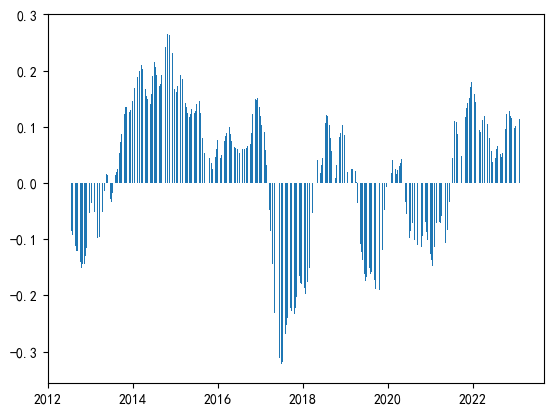

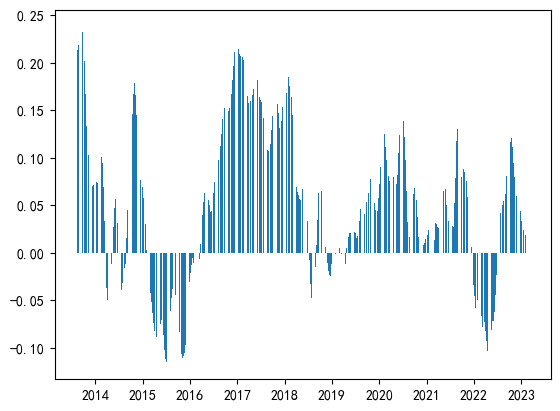

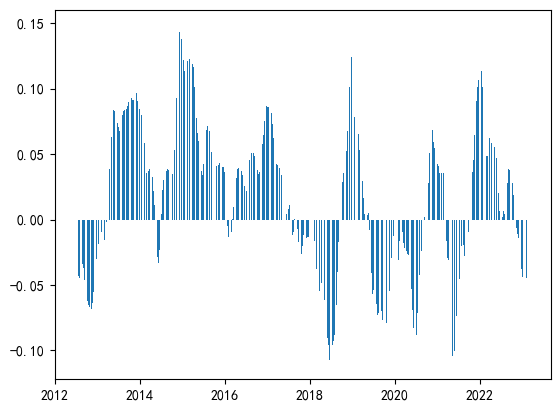

,dark,momentum,industry
dark,1.000000,-0.309649,0.477824
momentum,-0.309649,1.000000,-0.107893
industry,0.477824,-0.107893,1.000000


In [13]:
df_factor_1=df_factor.rolling(126).mean()  #取过去半年的ic均值
df_factor_2=df_factor_1.dropna()

#IC均值时序图
df_factor_new=df_factor_1.reset_index()
df_factor_new['date'] = pd.to_datetime(df_factor_new['date'])
plt.bar(df_factor_new['date'], df_factor_new['dark'])
plt.show()

df_factor_new['date'] = pd.to_datetime(df_factor_new['date'])
plt.bar(df_factor_new['date'], df_factor_new['momentum'])
plt.show()

df_factor_new['date'] = pd.to_datetime(df_factor_new['date'])
plt.bar(df_factor_new['date'], df_factor_new['industry'])
plt.show()

#因子IC值相关性
correlation_matrix = np.corrcoef(df_factor_2[['dark','momentum','industry']], rowvar=0)
correlation=pd.DataFrame(correlation_matrix)
correlation.columns=['dark','momentum','industry']
correlation.index=['dark','momentum','industry']
correlation

In [14]:
#ic X 标准化后的因子值
df_factor_2=pd.merge(position_fund_6.reset_index()[['date']],df_factor_1,how='outer',on='date').set_index('date').shift(21) #当天的因子权重要用过去21天的
df_factor_1_multiply=position_fund_6.merge(df_factor_2,how='left',on='date')  #匹配日期
df_dark_2=dark_std.multiply(df_factor_1_multiply['dark'],axis=0)  #标准化后的因子 x IC，日频
df_industry_2=industry_std.multiply(df_factor_1_multiply['industry'],axis=0)
df_momentum_2=momentum_std.multiply(df_factor_1_multiply['momentum'],axis=0)

In [15]:
#时序ic权重3因子
icfactor_3=df_dark_2+df_industry_2+df_momentum_2
icfactor_3_1=icfactor_3.resample('M').ffill().resample('D').ffill() #月频调仓
icfactor_3_month=pd.merge(icfactor_3_1,position_fund_6.reset_index()[['date']],how='inner',on='date').set_index('date')

factor_data3_2= alphalens.utils.get_clean_factor_and_forward_returns(icfactor_3_month.shift(1).stack(),
                                                                   fund_nav_final,
                                                                   groupby=None,
                                                                   binning_by_group=False,
                                                                   #quantiles=[0,0.1,1],
                                                                   quantiles=20,    ###################分层回测
                                                                   bins=None,
                                                                   periods=(1,),          # 持仓周期
                                                                   filter_zscore=5,
                                                                   groupby_labels=None,
                                                                   max_loss=1,               # 能容忍的最大缺省值百分比
                                                                   zero_aware=False,
                                                                   cumulative_returns=True)
# alphalens.tears.create_full_tear_sheet(factor_data3_2,long_short=False,
#                            group_neutral=False,
#                            by_group=False) 

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


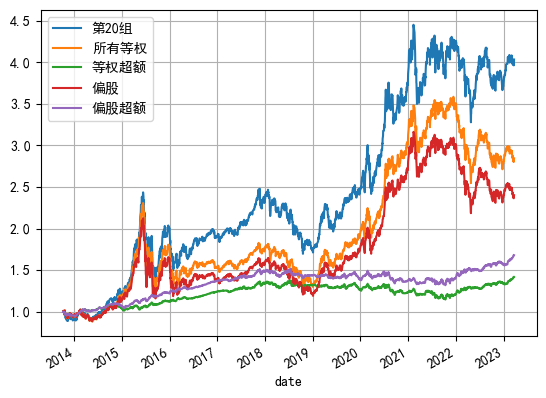

In [16]:
businessday1=businessday[['date','price']].set_index('date')
businessday1['price_1']=businessday1['price']/businessday1.iloc[0,0]

quant20_2=(factor_data3_2[factor_data3_2['factor_quantile']==20].groupby(by='date')['1D'].mean().shift(1).fillna(0)+1).cumprod() #画第20组
quant_2_all=(factor_data3_2.groupby(by='date')['1D'].mean().shift(1).fillna(0)+1).cumprod() #画所有等权
compare_2=pd.concat([quant20_2,quant_2_all,quant20_2/quant_2_all],axis=1)

compare_2_all=pd.merge(compare_2,businessday1,how='inner',on='date')
compare_2_all.columns=['第20组','所有等权','等权超额','price','偏股']
compare_2_all['偏股超额']=compare_2_all['第20组']/compare_2_all['偏股']
compare_2_all_1=compare_2_all[['第20组','所有等权','等权超额','偏股','偏股超额']]
compare_2_all_1['偏股超额']=compare_2_all_1['偏股超额']/compare_2_all_1['偏股超额'].tolist()[0]
compare_2_all_1['偏股']=compare_2_all_1['偏股']/compare_2_all_1['偏股'].tolist()[0]
compare_2_all_1.plot()
plt.grid()

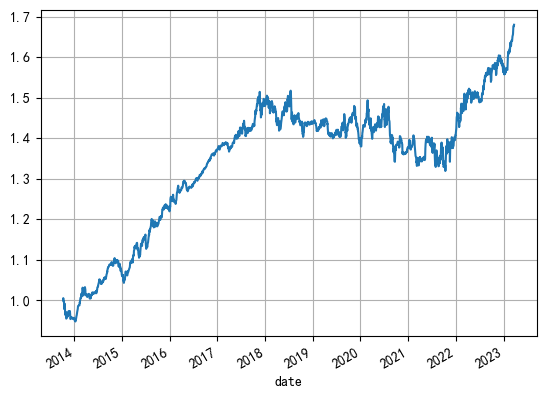

In [18]:
compare_2_all_1['偏股超额'].plot()
plt.grid()

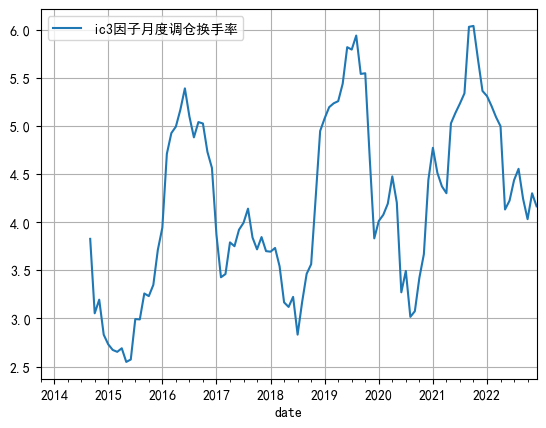

In [19]:
#计算月换手率（月度）
change_1_san=(factor_data3_2[factor_data3_2['factor_quantile']==20].unstack()['factor']).notnull()
change_2_san=change_1_san.resample('M').ffill()
change_3_san=change_2_san.shift(1)
change_4_san=change_3_san+change_2_san 
change_5_san=change_4_san==2 #若为True，说明下一期还有
change_san_rate=pd.DataFrame()
change_san_rate['换手率']=1-change_5_san.sum(axis=1)/change_2_san.sum(axis=1)#计算月换手率
change_san_plot=pd.DataFrame()
change_san_plot['ic3因子月度调仓换手率']=change_san_rate.rolling(12).sum()
change_san_plot.loc[:'2022-12-31'].plot()
plt.grid()

In [20]:
#导出最后一期选择的基金名单
factor_fund_2=factor_data3_2.reset_index() 
factor_fund_2_1=factor_fund_2[factor_fund_2['date']==last_date] 
factor_fund_2_2=factor_fund_2_1.sort_values('factor',ascending=False).head(20) 
factor_fund_2_2=factor_fund_2_2.rename(columns={'asset':'fund_code'}) 
factor_fund_2_3=factor_fund_2_2.merge(basic[['fund_code','shortname']],how='left',on='fund_code')

final_fund_3=factor_fund_2_3[['date','fund_code','factor','shortname']] 
final_fund_3_1=final_fund_3.merge(basic[['fund_code','investtype2','quant_flg']],how='left',on='fund_code') 
final_fund_3_2=final_fund_3_1.merge(position_fund_8,how='left',on=['date','fund_code']) 
final_fund_3_3=final_fund_3_2.merge(position_mkt_all_7,how='left',on=['date','fund_code']) 
final_fund_3_4=final_fund_3_3.merge(month_pct_5,how='left',on=['date','fund_code']) 

cm_3 = sns.light_palette("green", as_cmap=True) 
final_fund_3_7=final_fund_3_4.style.background_gradient(cmap=cm_3).set_precision(2) 
final_fund_3_7

,date,fund_code,factor,shortname,investtype2,quant_flg,黑马程度,行业分散度,动量
0,2022-03-22 00:00:00,540007.OF,0.56,汇丰晋信中小盘,普通股票型基金,非量化基金,2.47,1.18,-1.01
1,2022-03-22 00:00:00,005126.OF,0.54,银河量化稳进,偏股混合型基金,量化基金,2.37,1.79,0.10
2,2022-03-22 00:00:00,005053.OF,0.53,银河量化价值A,偏股混合型基金,量化基金,2.18,1.76,-0.20
3,2022-03-22 00:00:00,005443.OF,0.51,国金量化多策略A,灵活配置型基金,量化基金,2.47,1.60,0.60
4,2022-03-22 00:00:00,000893.OF,0.49,工银创新动力,普通股票型基金,非量化基金,2.40,1.44,0.52
5,2022-03-22 00:00:00,519097.OF,0.48,新华中小市值优选,偏股混合型基金,非量化基金,2.75,0.74,0.16
6,2022-03-22 00:00:00,006195.OF,0.47,国金量化多因子A,普通股票型基金,量化基金,2.25,1.66,0.79
7,2022-03-22 00:00:00,002871.OF,0.47,华夏智胜价值成长A,普通股票型基金,量化基金,2.00,1.94,0.77
8,2022-03-22 00:00:00,001421.OF,0.45,南方量化成长,普通股票型基金,量化基金,2.05,1.40,0.09
9,2022-03-22 00:00:00,460009.OF,0.45,华泰柏瑞量化先行A,偏股混合型基金,量化基金,1.95,1.78,0.58
